In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class AverageMeter():
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self,val, n=1):
        self.val = val
        self.count += n
        self.sum += val
        self.avg = self.sum / self.count
#define dataset
class TrueDataset(data.Dataset):
    def __init__(self):
        np.random.seed(0)
        self.dataset =  np.random.randn(200,2)+[6,6]#np.vstack([np.random.randn(10,2)+[6,6],np.random.randn(10,2)+[4,4]])
        self.max = np.max(self.dataset)
        #self.labels = np.ones(len(self.dataset))
    def __getitem__(self, idx):
        x = self.dataset[idx]
        y = 1
        return x, y
    def __len__(self):
        return len(self.dataset)
    def visualization(self):
        for p in self.dataset:
            plt.scatter(p[0],p[1])

In [3]:
def weights_init_classifier(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.02)
        nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
class BaseModel_D(nn.Module):
    def __init__(self):
        super(BaseModel_D, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(2,10),
                                   nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(10,10),
                                   nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(10,2))
        self.layer1.apply(weights_init_classifier)
        self.layer2.apply(weights_init_classifier)
        self.layer3.apply(weights_init_classifier)
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = nn.functional.sigmoid(self.layer3(output))
        return output
class BaseModel_G(nn.Module):
    def __init__(self):
        super(BaseModel_G, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(1,10))
        self.layer2 = nn.Sequential(nn.Linear(10,10))
        self.layer3 = nn.Sequential(nn.Linear(10,2))
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        return output

In [4]:
batch_size = 4
true_dataset = TrueDataset()
true_dataloader = torch.utils.data.DataLoader(true_dataset,batch_size=batch_size,shuffle=True,num_workers=4,drop_last=False)

loss_func_D = nn.CrossEntropyLoss()
model_D = BaseModel_D()
model_G = BaseModel_G()

optimizer_D = torch.optim.Adam(model_D.parameters(), lr=0.001, betas=(0.5, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer_G = torch.optim.Adam(model_G.parameters(), lr=0.001, betas=(0.5, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [5]:
nEpochs = 25
train_D_period = 3+1
eval_D_period = 1
logger_D = AverageMeter()
logger_G = AverageMeter()
for epoch in range(1,nEpochs+1):
    if epoch % train_D_period != 0:    #train D for 1 epochs
        logger_D.reset()
        model_G.eval()
        model_D.train()
        for idx,(input,target) in enumerate(true_dataloader):
            #input = input.cuda()
            #target = target.cuda()
            input = input.float()
            output_D = model_D(input)
            optimizer_D.zero_grad()
            loss1 = loss_func_D(output_D, target)
            logger_D.update(loss1.item(),input.shape[0])
            loss1.backward()
            #optimizer_D.step()
            np.random.seed(idx)
            
            input = torch.from_numpy(np.random.randn(batch_size,1)).float()
            output_G = model_G(input)
            output_D = model_D(output_G)
            target = target.fill_(0)
            #optimizer_D.zero_grad()
            loss2 = loss_func_D(output_D, target)
            logger_D.update(loss2.item(),input.shape[0])

            loss2.backward()
            loss = loss1+loss2
            optimizer_D.step()
        print("epoch:{}/{} D loss: {:.4f}".format(epoch,nEpochs,logger_D.avg))
        
            
    else: #train G for 1 epoch
        logger_G.reset()
        model_G.train()
        model_D.eval()
        for idx,(input,target) in enumerate(true_dataloader):
            #input = input.cuda()
            #target = target.cuda()
            np.random.seed(idx)
            input = torch.from_numpy(np.random.randn(batch_size,1)).float()
            target = target.fill_(1)
            #print(target)
            output_G = model_G(input)
            output_D = model_D(output_G)
            optimizer_G.zero_grad()
            loss = loss_func_D(output_D, target)
            logger_G.update(loss.item(),input.shape[0])
            loss.backward()
            optimizer_G.step()
        
        print("epoch:{}/{} G loss: {:.4f}".format(epoch,nEpochs,logger_G.avg))
    
    if epoch % eval_D_period == 0:
        model_D.eval()
        running_corrects = 0
        for idx,(input,target) in enumerate(true_dataloader):
            input = input.float()
            output_D = model_D(input)
            _, preds = torch.max(output_D, 1)
            running_corrects += torch.sum(preds == target.data)
            
            np.random.seed(idx) 
            input = torch.from_numpy(np.random.randn(batch_size,1)).float()
            target = target.fill_(0)
            output_G = model_G(input)
            output_D = model_D(output_G)
            _, preds = torch.max(output_D, 1)
            running_corrects += torch.sum(preds == target.data)
        #print(len(true_dataloader.dataset)+len(false_dataloader.dataset))
        running_acc = running_corrects.double()/(2*len(true_dataloader.dataset))
        print('D acc:{:.3f}'.format(running_acc))

/data/lujj/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:1/25 D loss: 0.1714
D acc:1.000
epoch:2/25 D loss: 0.1477
D acc:1.000
epoch:3/25 D loss: 0.1110
D acc:1.000
epoch:4/25 G loss: 0.2410
D acc:0.990
epoch:5/25 D loss: 0.1027
D acc:1.000
epoch:6/25 D loss: 0.0906
D acc:1.000
epoch:7/25 D loss: 0.0851
D acc:1.000
epoch:8/25 G loss: 0.2950
D acc:0.960
epoch:9/25 D loss: 0.0880
D acc:1.000
epoch:10/25 D loss: 0.0831
D acc:1.000
epoch:11/25 D loss: 0.0813
D acc:1.000
epoch:12/25 G loss: 0.2961
D acc:0.882
epoch:13/25 D loss: 0.0978
D acc:0.958
epoch:14/25 D loss: 0.0955
D acc:0.958
epoch:15/25 D loss: 0.0940
D acc:0.955
epoch:16/25 G loss: 0.2529
D acc:0.770
epoch:17/25 D loss: 0.1341
D acc:0.785
epoch:18/25 D loss: 0.1335
D acc:0.782
epoch:19/25 D loss: 0.1328
D acc:0.785
epoch:20/25 G loss: 0.1700
D acc:0.585
epoch:21/25 D loss: 0.1850
D acc:0.585
epoch:22/25 D loss: 0.1848
D acc:0.585
epoch:23/25 D loss: 0.1846
D acc:0.585
epoch:24/25 G loss: 0.0962
D acc:0.492
epoch:25/25 D loss: 0.2044
D acc:0.500


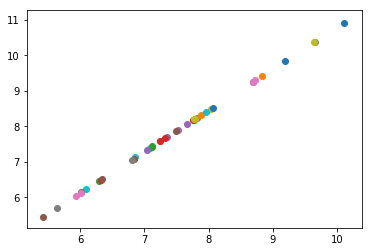

In [6]:
genenrate_data = []
model_G.eval()
for idx in range(10):
    with torch.no_grad():
        input = torch.from_numpy(np.random.randn(batch_size,1)).float()
        output_G = model_G(input)
        genenrate_data.append(output_G.numpy())
genenrate_data = np.concatenate(genenrate_data,0)
for p in genenrate_data:
    plt.scatter(p[0],p[1])

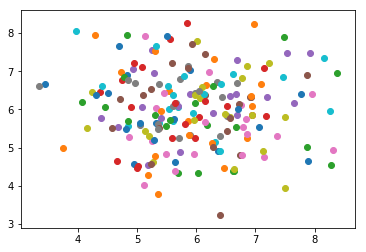

In [7]:
true_dataset.visualization()